# Description

It analyzes how correlation coefficients intersect on different gene pairs. Basically, I take the top gene pairs with the maximum correlation coefficient according to Pearson, Spearman and Clustermatch, and also the equivalent set with the minimum coefficient values, and then compare how these sets intersect each other.

After identifying different intersection sets, I plot some gene pairs to see what's being captured or not by each coefficient.

# Modules

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from upsetplot import plot, from_indicators

from clustermatch.plots import MyUpSet
from clustermatch import conf

# Settings

In [2]:
DATASET_CONFIG = conf.GTEX
GTEX_TISSUE = "whole_blood"
GENE_SEL_STRATEGY = "var_pc_log2"

In [3]:
# this specificies the threshold to compare coefficients (see below).
# it basically takes the top Q_DIFF coefficient values for gene pairs
# and compare with the bottom Q_DIFF of the other coefficients
Q_DIFF = 0.30

# Paths

In [4]:
assert (
    conf.MANUSCRIPT["BASE_DIR"] is not None and conf.MANUSCRIPT["BASE_DIR"].exists()
), "Manuscript dir not set"

In [5]:
OUTPUT_FIGURE_DIR = (
    conf.MANUSCRIPT["FIGURES_DIR"] / "coefs_comp" / f"gtex_{GTEX_TISSUE}"
)
OUTPUT_FIGURE_DIR.mkdir(parents=True, exist_ok=True)
display(OUTPUT_FIGURE_DIR)

PosixPath('/opt/manuscript/content/images/coefs_comp/gtex_whole_blood')

In [6]:
INPUT_CORR_FILE_TEMPLATE = (
    DATASET_CONFIG["SIMILARITY_MATRICES_DIR"]
    / DATASET_CONFIG["SIMILARITY_MATRIX_FILENAME_TEMPLATE"]
)
display(INPUT_CORR_FILE_TEMPLATE)

PosixPath('/opt/data/results/gtex_v8/similarity_matrices/gtex_v8_data_{tissue}-{gene_sel_strategy}-{corr_method}.pkl')

In [7]:
INPUT_CORR_FILE = DATASET_CONFIG["SIMILARITY_MATRICES_DIR"] / str(
    INPUT_CORR_FILE_TEMPLATE
).format(
    tissue=GTEX_TISSUE,
    gene_sel_strategy=GENE_SEL_STRATEGY,
    corr_method="all",
)
display(INPUT_CORR_FILE)

assert INPUT_CORR_FILE.exists()

PosixPath('/opt/data/results/gtex_v8/similarity_matrices/gtex_v8_data_whole_blood-var_pc_log2-all.pkl')

# Data

## Correlation

In [8]:
df = pd.read_pickle(INPUT_CORR_FILE)

In [9]:
df.shape

(12497500, 3)

In [10]:
df.head()

clustermatch   pearson  spearman
ENSG00000000419.12 ENSG00000002834.17      0.418721  0.681847  0.786595
                   ENSG00000002919.14      0.405090  0.734699  0.816991
                   ENSG00000002933.7       0.007466  0.013825  0.004128
                   ENSG00000003402.19      0.391683  0.727347  0.803653
                   ENSG00000004478.7       0.099013  0.094147  0.231269

In [11]:
# FIXME: this will not be necessary in new runs of clustermatch on GTEx
df.loc[df["clustermatch"] < 0, "clustermatch"] = 0.0

In [12]:
df.describe()

,clustermatch,pearson,spearman
count,1.249750e+07,1.249750e+07,1.249750e+07
mean,1.407816e-01,3.055270e-01,3.944421e-01
std,1.448215e-01,2.432962e-01,2.595311e-01
min,0.000000e+00,1.507747e-08,1.394156e-08
25%,2.840490e-02,9.442322e-02,1.629740e-01
50%,8.111060e-02,2.388613e-01,3.675595e-01
75%,2.167198e-01,4.953854e-01,6.148954e-01
max,9.169180e-01,9.948780e-01,9.867424e-01


In [13]:
# show quantiles
df.apply(lambda x: x.quantile(np.linspace(0.20, 1.0, 20)))

,clustermatch,pearson,spearman
0.200000,0.022719,0.072940,0.128198
0.242105,0.027466,0.090891,0.157408
0.284211,0.032678,0.110196,0.187676
0.326316,0.038882,0.131066,0.219424
0.368421,0.046496,0.153705,0.253012
0.410526,0.054956,0.178290,0.288341
0.452632,0.065748,0.205194,0.324886
0.494737,0.079110,0.234929,0.362750
0.536842,0.094529,0.267921,0.401768
0.578947,0.112897,0.304762,0.441738


# Prepare data for plotting

In [14]:
def get_lower_upper_quantile(method_name, q):
    return df[method_name].quantile([q, 1 - q])

In [15]:
# test
_tmp = get_lower_upper_quantile("clustermatch", 0.20)
display(_tmp)

_tmp0, _tmp1 = _tmp
display((_tmp0, _tmp1))

assert _tmp0 == _tmp.iloc[0]
assert _tmp1 == _tmp.iloc[1]

0.2    0.022719
0.8    0.259050
Name: clustermatch, dtype: float64

(0.02271880444305697, 0.259049765543866)

In [16]:
clustermatch_lq, clustermatch_hq = get_lower_upper_quantile("clustermatch", Q_DIFF)
display((clustermatch_lq, clustermatch_hq))

pearson_lq, pearson_hq = get_lower_upper_quantile("pearson", Q_DIFF)
display((pearson_lq, pearson_hq))

spearman_lq, spearman_hq = get_lower_upper_quantile("spearman", Q_DIFF)
display((spearman_lq, spearman_hq))

(0.034958339010692396, 0.18194034996376532)

(0.11783518340101658, 0.43471104354487755)

(0.1993565001342337, 0.5627397462227566)

In [17]:
pearson_higher = df["pearson"] >= pearson_hq
display(pearson_higher.sum())

pearson_lower = df["pearson"] <= pearson_lq
display(pearson_lower.sum())

3749250

3749250

In [18]:
spearman_higher = df["spearman"] >= spearman_hq
display(spearman_higher.sum())

spearman_lower = df["spearman"] <= spearman_lq
display(spearman_lower.sum())

3749250

3749250

In [19]:
clustermatch_higher = df["clustermatch"] >= clustermatch_hq
display(clustermatch_higher.sum())

clustermatch_lower = df["clustermatch"] <= clustermatch_lq
display(clustermatch_lower.sum())

3754664

3749265

# UpSet plot

In [20]:
df_plot = pd.DataFrame(
    {
        "pearson_higher": pearson_higher,
        "pearson_lower": pearson_lower,
        "spearman_higher": spearman_higher,
        "spearman_lower": spearman_lower,
        "clustermatch_higher": clustermatch_higher,
        "clustermatch_lower": clustermatch_lower,
    }
)

In [21]:
df_plot = pd.concat([df_plot, df], axis=1)

In [22]:
df_plot

pearson_higher  pearson_lower  \
ENSG00000000419.12 ENSG00000002834.17            True          False   
                   ENSG00000002919.14            True          False   
                   ENSG00000002933.7            False           True   
                   ENSG00000003402.19            True          False   
                   ENSG00000004478.7            False           True   
...                                               ...            ...   
ENSG00000284574.1  ENSG00000282651.2            False           True   
                   ENSG00000282780.1            False           True   
                   ENSG00000282939.1            False           True   
                   ENSG00000283063.1            False           True   
                   ENSG00000283602.1            False           True   

                                       spearman_higher  spearman_lower  \
ENSG00000000419.12 ENSG00000002834.17             True           False   
                   ENSG00000002919.14             True           False   
                   ENSG00000002933.7             False            True   
                   ENSG00000003402.19             True           False   
                   ENSG00000004478.7             False           False   
...                                                ...             ...   
ENSG00000284574.1  ENSG00000282651.2             False            True   
                   ENSG00000282780.1             False            True   
                   ENSG00000282939.1             False            True   
                   ENSG00000283063.1             False            True   
                   ENSG00000283602.1             False            True   

                                       clustermatch_higher  \
ENSG00000000419.12 ENSG00000002834.17                 True   
                   ENSG00000002919.14                 True   
                   ENSG00000002933.7                 False   
                   ENSG00000003402.19                 True   
                   ENSG00000004478.7                 False   
...                                                    ...   
ENSG00000284574.1  ENSG00000282651.2                 False   
                   ENSG00000282780.1                 False   
                   ENSG00000282939.1                 False   
                   ENSG00000283063.1                 False   
                   ENSG00000283602.1                 False   

                                       clustermatch_lower  clustermatch  \
ENSG00000000419.12 ENSG00000002834.17               False      0.418721   
                   ENSG00000002919.14               False      0.405090   
                   ENSG00000002933.7                 True      0.007466   
                   ENSG00000003402.19               False      0.391683   
                   ENSG00000004478.7                False      0.099013   
...                                                   ...           ...   
ENSG00000284574.1  ENSG00000282651.2                 True      0.011968   
                   ENSG00000282780.1                 True      0.004975   
                   ENSG00000282939.1                 True      0.011968   
                   ENSG00000283063.1                 True      0.006638   
                   ENSG00000283602.1                 True      0.013967   

                                        pearson  spearman  
ENSG00000000419.12 ENSG00000002834.17  0.681847  0.786595  
                   ENSG00000002919.14  0.734699  0.816991  
                   ENSG00000002933.7   0.013825  0.004128  
                   ENSG00000003402.19  0.727347  0.803653  
                   ENSG00000004478.7   0.094147  0.231269  
...                                         ...       ...  
ENSG00000284574.1  ENSG00000282651.2   0.051215  0.089428  
                   ENSG00000282780.1   0.031741  0.018411  
                   ENSG00000282939.1   0.029699  0.104518  
                   ENSG00000283063.1   

In [23]:
assert not df_plot.isna().any().any()

In [24]:
df_plot = df_plot.rename(
    columns={
        "pearson_higher": "Pearson (high)",
        "pearson_lower": "Pearson (low)",
        "spearman_higher": "Spearman (high)",
        "spearman_lower": "Spearman (low)",
        "clustermatch_higher": "Clustermatch (high)",
        "clustermatch_lower": "Clustermatch (low)",
    }
)

In [25]:
categories = sorted(
    [x for x in df_plot.columns if " (" in x],
    reverse=True,
    key=lambda x: x.split(" (")[1] + " (" + x.split(" (")[0],
)

In [26]:
categories

['Spearman (low)',
 'Pearson (low)',
 'Clustermatch (low)',
 'Spearman (high)',
 'Pearson (high)',
 'Clustermatch (high)']

## All subsets (original full plot)

In [27]:
df_r_data = df_plot

In [28]:
df_r_data.shape

(12497500, 9)

In [29]:
gene_pairs_by_cats = from_indicators(categories, data=df_r_data)

In [30]:
gene_pairs_by_cats

Pearson (high)  \
Spearman (low) Pearson (low) Clustermatch (low) Spearman (high) Pearson (high) Clustermatch (high)                   
False          False         False              True            True           True                           True   
                                                                               True                           True   
True           True          True               False           False          False                         False   
False          False         False              True            True           True                           True   
               True          False              False           False          False                         False   
...                                                                                                            ...   
True           True          True               False           False          False                         False   
                                                                               False                         False   
                                                                               False                         False   
                                                                               False                         False   
                                                                               False                         False   

                                                                                                    Pearson (low)  \
Spearman (low) Pearson (low) Clustermatch (low) Spearman (high) Pearson (high) Clustermatch (high)                  
False          False         False              True            True           True                         False   
                                                                               True                         False   
True           True          True               False           False          False                         True   
False          False         False              True            True           True                         False   
               True          False              False           False          False                         True   
...                                                                                                           ...   
True           True          True               False           False          False                         True   
                                                                               False                         True   
                                                                               False                         True   
                                                                               False                         True   
                                                                               False                         True   

                                                                                                    Spearman (high)  \
Spearman (low) Pearson (low) Clustermatch (low) Spearman (high) Pearson (high) Clustermatch (high)                    
False          False         False              True            True           True                            True   
                                                                               True                            True   
True           True          True               False           False          False                          False   
False          False         False              True            True           True                            True   
               True          False              False           False          False                          False   
...                                                                                                             ...   
True           True          True               False           False          False       

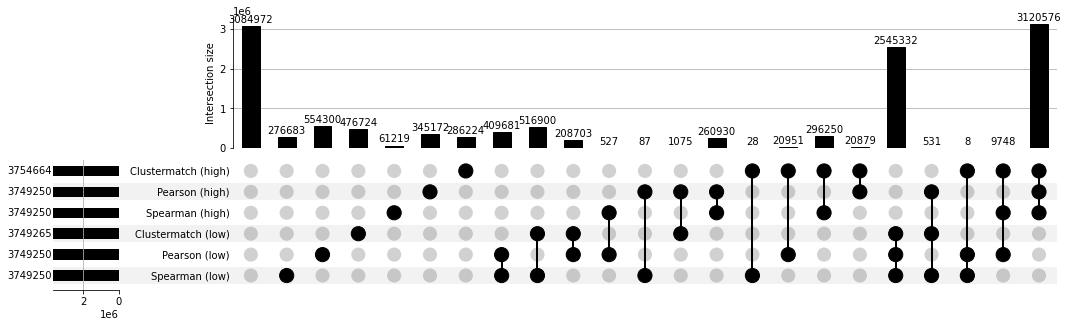

In [31]:
fig = plt.figure(figsize=(18, 5))

g = plot(
    gene_pairs_by_cats,
    show_counts=True,
    sort_categories_by=None,
    element_size=None,
    fig=fig,
)

## Sort by categories of subsets

In [32]:
df_r_data = df_plot

In [33]:
df_r_data.shape

(12497500, 9)

In [34]:
gene_pairs_by_cats = from_indicators(categories, data=df_r_data)

In [35]:
gene_pairs_by_cats

Pearson (high)  \
Spearman (low) Pearson (low) Clustermatch (low) Spearman (high) Pearson (high) Clustermatch (high)                   
False          False         False              True            True           True                           True   
                                                                               True                           True   
True           True          True               False           False          False                         False   
False          False         False              True            True           True                           True   
               True          False              False           False          False                         False   
...                                                                                                            ...   
True           True          True               False           False          False                         False   
                                                                               False                         False   
                                                                               False                         False   
                                                                               False                         False   
                                                                               False                         False   

                                                                                                    Pearson (low)  \
Spearman (low) Pearson (low) Clustermatch (low) Spearman (high) Pearson (high) Clustermatch (high)                  
False          False         False              True            True           True                         False   
                                                                               True                         False   
True           True          True               False           False          False                         True   
False          False         False              True            True           True                         False   
               True          False              False           False          False                         True   
...                                                                                                           ...   
True           True          True               False           False          False                         True   
                                                                               False                         True   
                                                                               False                         True   
                                                                               False                         True   
                                                                               False                         True   

                                                                                                    Spearman (high)  \
Spearman (low) Pearson (low) Clustermatch (low) Spearman (high) Pearson (high) Clustermatch (high)                    
False          False         False              True            True           True                            True   
                                                                               True                            True   
True           True          True               False           False          False                          False   
False          False         False              True            True           True                            True   
               True          False              False           False          False                          False   
...                                                                                                             ...   
True           True          True               False           False          False       

In [36]:
gene_pairs_by_cats = gene_pairs_by_cats.sort_index()

In [37]:
_tmp_index = gene_pairs_by_cats.index.unique().to_frame(False)
display(_tmp_index)

,Spearman (low),Pearson (low),Clustermatch (low),Spearman (high),Pearson (high),Clustermatch (high)
0,False,False,False,False,False,False
1,False,False,False,False,False,True
2,False,False,False,False,True,False
3,False,False,False,False,True,True
4,False,False,False,True,False,False
5,False,False,False,True,False,True
6,False,False,False,True,True,False
7,False,False,False,True,True,True
8,False,False,True,False,False,False
9,False,False,True,False,True,False


In [38]:
_tmp_index[_tmp_index.sum(axis=1) == 3]

,Spearman (low),Pearson (low),Clustermatch (low),Spearman (high),Pearson (high),Clustermatch (high)
7,False,False,False,True,True,True
13,False,True,False,True,False,True
19,True,False,True,False,True,False
21,True,True,False,False,False,True
22,True,True,True,False,False,False


In [39]:
_tmp_index.apply(lambda x: x[0:3].sum() == 0, axis=1)

0      True
1      True
2      True
3      True
4      True
5      True
6      True
7      True
8     False
9     False
10    False
11    False
12    False
13    False
14    False
15    False
16    False
17    False
18    False
19    False
20    False
21    False
22    False
dtype: bool

In [40]:
# agreements on top
_tmp_index.loc[
    _tmp_index[
        _tmp_index.apply(lambda x: x.sum() > 1, axis=1)
        & _tmp_index.apply(lambda x: x[0:3].sum() == 0, axis=1)
        & _tmp_index.apply(lambda x: 3 > x[3:].sum() > 1, axis=1)
    ].index
].apply(tuple, axis=1).to_numpy()

array([(False, False, False, False, True, True),
       (False, False, False, True, False, True),
       (False, False, False, True, True, False)], dtype=object)

In [41]:
# agreements on bottom
_tmp_index.loc[
    _tmp_index[
        _tmp_index.apply(lambda x: x.sum() > 1, axis=1)
        & _tmp_index.apply(lambda x: 3 > x[0:3].sum() > 1, axis=1)
        & _tmp_index.apply(lambda x: x[3:].sum() == 0, axis=1)
    ].index
].apply(tuple, axis=1).to_numpy()

array([(False, True, True, False, False, False),
       (True, False, True, False, False, False),
       (True, True, False, False, False, False)], dtype=object)

In [42]:
# diagreements
_tmp_index.loc[
    _tmp_index[
        _tmp_index.apply(lambda x: x.sum() > 1, axis=1)
        & _tmp_index.apply(lambda x: x[0:3].sum() > 0, axis=1)
        & _tmp_index.apply(lambda x: x[3:].sum() > 0, axis=1)
    ].index
].apply(tuple, axis=1).to_numpy()

array([(False, False, True, False, True, False),
       (False, True, False, False, False, True),
       (False, True, False, True, False, False),
       (False, True, False, True, False, True),
       (True, False, False, False, False, True),
       (True, False, False, False, True, False),
       (True, False, True, False, True, False),
       (True, True, False, False, False, True)], dtype=object)

In [43]:
# order subsets
gene_pairs_by_cats = gene_pairs_by_cats.loc[
    [
        # pairs not included in categories:
        # (False, False, False, False, False, False),
        # full agreements on high:
        (False, False, False, True, True, True),
        # agreements on top
        (False, False, False, False, True, True),
        (False, False, False, True, False, True),
        (False, False, False, True, True, False),
        # agreements on bottom
        (False, True, True, False, False, False),
        (True, False, True, False, False, False),
        (True, True, False, False, False, False),
        # full agreements on low:
        (True, True, True, False, False, False),
        # diagreements
        #   clustermatch
        (False, True, False, True, False, True),
        (False, True, False, False, False, True),
        (True, False, False, False, False, True),
        (True, True, False, False, False, True),
        #   pearson
        (False, False, True, False, True, False),
        (True, False, False, False, True, False),
        (True, False, True, False, True, False),
        #   spearman
        (False, True, False, True, False, False),
    ]
]

In [44]:
gene_pairs_by_cats.head()

Pearson (high)  \
Spearman (low) Pearson (low) Clustermatch (low) Spearman (high) Pearson (high) Clustermatch (high)                   
False          False         False              True            True           True                           True   
                                                                               True                           True   
                                                                               True                           True   
                                                                               True                           True   
                                                                               True                           True   

                                                                                                    Pearson (low)  \
Spearman (low) Pearson (low) Clustermatch (low) Spearman (high) Pearson (high) Clustermatch (high)                  
False          False         False              True            True           True                         False   
                                                                               True                         False   
                                                                               True                         False   
                                                                               True                         False   
                                                                               True                         False   

                                                                                                    Spearman (high)  \
Spearman (low) Pearson (low) Clustermatch (low) Spearman (high) Pearson (high) Clustermatch (high)                    
False          False         False              True            True           True                            True   
                                                                               True                            True   
                                                                               True                            True   
                                                                               True                            True   
                                                                               True                            True   

                                                                                                    Spearman (low)  \
Spearman (low) Pearson (low) Clustermatch (low) Spearman (high) Pearson (high) Clustermatch (high)                   
False          False         False              True            True           True                          False   
                                                                               True                          False   
                                                                               True                          False   
                                                                               True                          False   
                                                                               True                          False   

                                                                                                    Clustermatch (high)  \
Spearman (low) Pearson (low) Clustermatch (low) Spearman (high) Pearson (high) Clustermatch (high)                        
False          False         False              True            True           True                                True   
                                                                               True                                True   
                                                                               True                                True   
                                                                               True                                True   
                                                      

In [45]:
gene_pairs_by_cats = gene_pairs_by_cats.rename(
    columns={
        "Clustermatch (high)": "CCC (high)",
        "Clustermatch (low)": "CCC (low)",
    }
)

gene_pairs_by_cats.index.set_names(
    {
        "Clustermatch (high)": "CCC (high)",
        "Clustermatch (low)": "CCC (low)",
    },
    inplace=True,
)

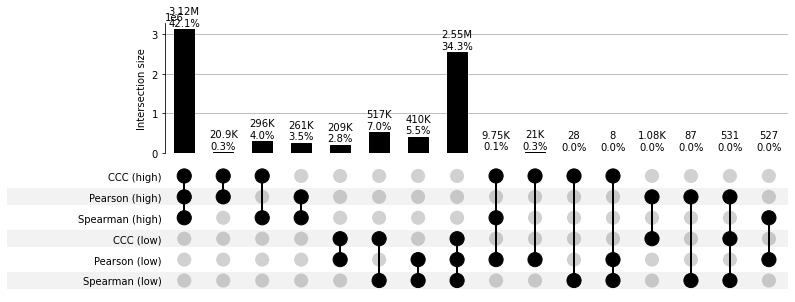

In [46]:
fig = plt.figure(figsize=(14, 5))

# g = plot(
g = MyUpSet(
    gene_pairs_by_cats,
    show_counts=True,
    sort_categories_by=None,
    sort_by=None,
    show_percentages=True,
    # min_subset_size=2,
    element_size=None,
    # fig=fig,
).plot(fig)

g["totals"].remove()  # set_visible(False)

# display(fig.get_size_inches())
# fig.set_size_inches(12, 5)

plt.savefig(
    OUTPUT_FIGURE_DIR / "upsetplot.svg",
    bbox_inches="tight",
    facecolor="white",
)

# plt.margins(x=-0.4)

This plot has the sets that represent agreements on the left, and disagreements on the right.

The plot shown here is **not the final one for the manuscript**:

1. Open the main output svg file (`upsetplot-main.svg`)
1. Include the file generated here (`upsetplot.svg`)
1. Rearrange the `1e6` at the top, which is overlapping other numbers.
1. Add the triangles (red and green). For this I need to move the category names at the left to make space.
1. Add a rectangle and clip it to remove the extra space on the left
1. Add the "Agreements" and "Disagreements" labels below.
1. Automatically resize page to drawing.
1. Add a rectangle that covers the entire drawing with white background. And send it to the background.

# Save groups of gene pairs in each subset

In [47]:
display(df_plot.shape)
display(df_plot.head())

(12497500, 9)

Pearson (high)  Pearson (low)  \
ENSG00000000419.12 ENSG00000002834.17            True          False   
                   ENSG00000002919.14            True          False   
                   ENSG00000002933.7            False           True   
                   ENSG00000003402.19            True          False   
                   ENSG00000004478.7            False           True   

                                       Spearman (high)  Spearman (low)  \
ENSG00000000419.12 ENSG00000002834.17             True           False   
                   ENSG00000002919.14             True           False   
                   ENSG00000002933.7             False            True   
                   ENSG00000003402.19             True           False   
                   ENSG00000004478.7             False           False   

                                       Clustermatch (high)  \
ENSG00000000419.12 ENSG00000002834.17                 True   
                   ENSG00000002919.14                 True   
                   ENSG00000002933.7                 False   
                   ENSG00000003402.19                 True   
                   ENSG00000004478.7                 False   

                                       Clustermatch (low)  clustermatch  \
ENSG00000000419.12 ENSG00000002834.17               False      0.418721   
                   ENSG00000002919.14               False      0.405090   
                   ENSG00000002933.7                 True      0.007466   
                   ENSG00000003402.19               False      0.391683   
                   ENSG00000004478.7                False      0.099013   

                                        pearson  spearman  
ENSG00000000419.12 ENSG00000002834.17  0.681847  0.786595  
                   ENSG00000002919.14  0.734699  0.816991  
                   ENSG00000002933.7   0.013825  0.004128  
                   ENSG00000003402.19  0.727347  0.803653  
                   ENSG00000004478.7   0.094147  0.231269

In [48]:
conf.GTEX["GENE_PAIR_INTERSECTIONS"].mkdir(parents=True, exist_ok=True)

In [49]:
output_file = (
    conf.GTEX["GENE_PAIR_INTERSECTIONS"]
    / f"gene_pair_intersections-gtex_v8-{GTEX_TISSUE}-{GENE_SEL_STRATEGY}.pkl"
)
display(output_file)

PosixPath('/opt/data/results/gtex_v8/gene_pair_intersections/gene_pair_intersections-gtex_v8-whole_blood-var_pc_log2.pkl')

In [50]:
df_plot.to_pickle(output_file)